In [1]:
import os
n_cores = 4
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count={}'.format(n_cores)

from jax.config import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp
import numpy as np
import pickle
from jax import jit, vmap, grad
import jax.random as random
key = random.PRNGKey(2022)
import jax.example_libraries.optimizers as optimizers
from jax.flatten_util import ravel_pytree
from jax.sharding import PositionalSharding
from functools import partial

import matplotlib.pyplot as plt
import pandas as pd

from utils import train, eval_Cauchy_aniso, eval_Cauchy_aniso_vmap
from utils import train_colloc_parallel as train_colloc, init_params_nn, ff_nn, divergence, bd_forces, a1, a2, lr
from utils_node import NODE, init_layers, NODE_model_aniso, init_params_aniso, GOH_model
from fem import plotmesh, fe_solver_2D, vahid_anisohyper_inv, apply_bc_biax

from jax.scipy.optimize import minimize
from jaxinterp2d import interp2d

In [2]:
def goh_P(lmbx, lmby, params):
    C10, k1, k2, kappa, theta = params
    C10, k1, k2, kappa = jnp.exp(C10), jnp.exp(k1), jnp.exp(k2), jnp.exp(-kappa**2)*0.3

    lmbz = 1.0/(lmbx*lmby)
    F = jnp.array([[lmbx, 0, 0],
                   [0, lmby, 0],
                   [0, 0, lmbz]])
    C = F.T @ F
    C2 = C @ C
    Cinv = jnp.linalg.inv(C)
    v0 = jnp.array([jnp.sin(theta), jnp.cos(theta), 0])
    V0 = jnp.outer(v0, v0)

    I1 = C[0,0] + C[1,1] + C[2,2]
    trC2 = C2[0,0] + C2[1,1] + C2[2,2]
    I2 = 0.5*(I1**2 - trC2)
    Iv = jnp.einsum('ij,ij',C,V0)

    E = kappa*(I1-3.0) + (1-3*kappa)*(Iv-1.0)
    E = jnp.maximum(E, 0.0)

    Psi1 = C10 + k1*kappa*E*jnp.exp(k2*E**2)
    Psiv = k1*(1-3*kappa)*E*jnp.exp(k2*E**2)
    Psi2 = 0.0
    Psiw = 0.0

    p = -C[2,2]*(2*Psi1 + 2*Psi2*(I1 - C[2,2]) + 2*Psiv*V0[2,2])
    S = p*Cinv + 2*Psi1*jnp.eye(3) + 2*Psi2*(I1*jnp.eye(3)-C) + 2*Psiv*V0

    P = F @ S
    return P
goh_P_vmap = vmap(goh_P, in_axes=(0,0,0))

In [3]:
with open('params/circ_multistep_s5_pre.npy', 'rb') as f:
    coord_2_strain_params, node_params, Lambda_params, node_X, elements, n_node, Fx, Fy, strains, \
                 bd_X, lmb_hist, sigma_hist_goh, F_hist_goh, node_x_hist_goh, t_hist = pickle.load(f)

element_x = np.array([np.mean(node_X[element][:,0]) for element in elements])
element_x = element_x - np.min(element_x)
element_x = element_x/np.max(element_x)

element_y = np.array([np.mean(node_X[element][:,1]) for element in elements])
element_y = element_y - np.min(element_y)
element_y = element_y/np.max(element_y)
element_X = np.array([element_x, element_y]).T

rgt_bd_elems = []
top_bd_elems = []
lft_bd_elems = []
bot_bd_elems = []
for i, e in enumerate(elements):
    if any([node_X[e[i],0]>0.99 for i in range(4)]):
        rgt_bd_elems.append(i)
    if any([node_X[e[i],1]>0.99 for i in range(4)]):
        top_bd_elems.append(i)
    if any([node_X[e[i],0]<0.01 for i in range(4)]):
        lft_bd_elems.append(i)
    if any([node_X[e[i],1]<0.01 for i in range(4)]):
        bot_bd_elems.append(i)

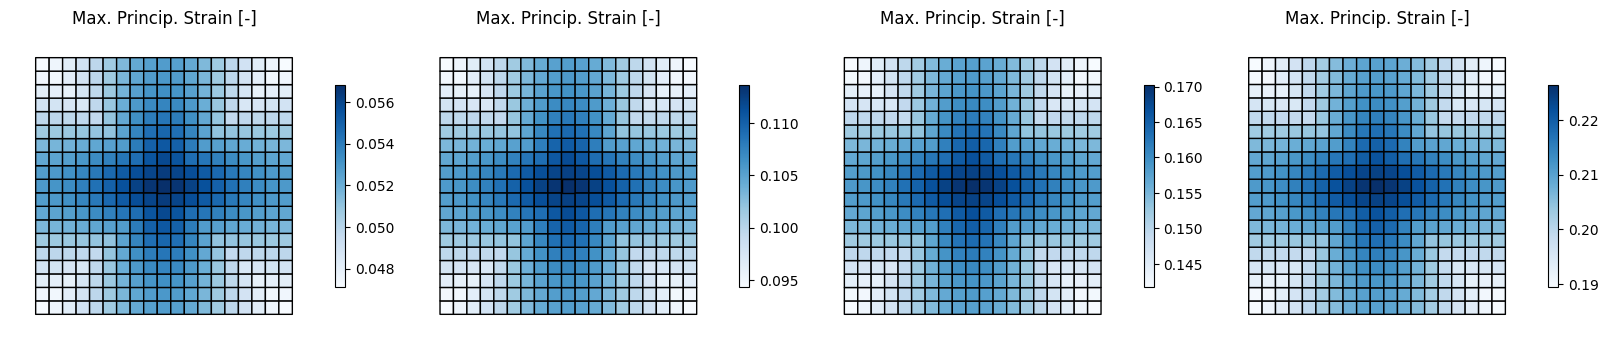

In [4]:
fig, axes = plt.subplots(1,4,figsize=(20,4))
strains = []
for t, node_x, F, sigma, ax in zip(t_hist, node_x_hist_goh, F_hist_goh, sigma_hist_goh, axes):
    eps_xx = F[:,0,0]-1.0
    eps_yy = F[:,1,1]-1.0

    mps = np.maximum(eps_xx, eps_yy)
    strains.append(np.array([t*np.ones_like(eps_xx), eps_xx, eps_yy]))

    plotmesh(elements, node_x, mps, title='Max. Princip. Strain [-]', ax=ax); 
strains = np.hstack(strains)

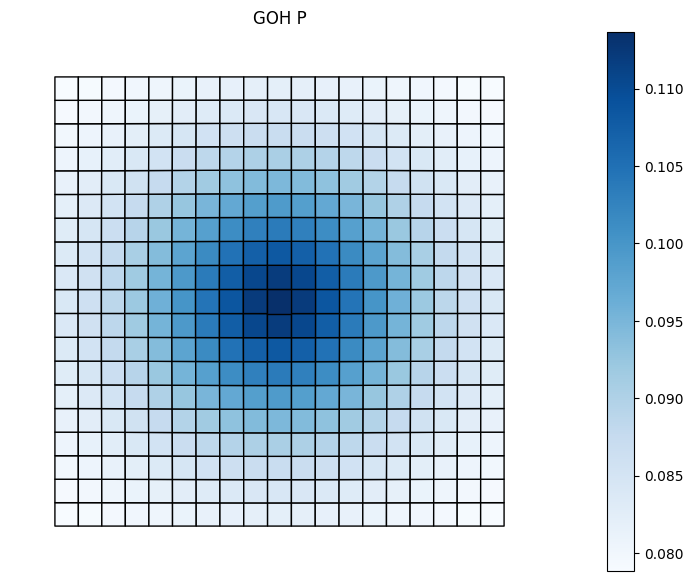

In [5]:
lmbx = F_hist_goh[-1,:,0,0]
lmby = F_hist_goh[-1,:,1,1]

C10 = -5.0
k1 = 0.0
k2 = 0.0
kappa = 0.2
theta = 0.1
params = np.array([[C10, k1, k2, kappa, theta]])
params = np.repeat(params, len(lmbx), axis=0)
P = goh_P_vmap(lmbx, lmby, params)
P = P[:,:2,:2]
plotmesh(elements, node_x, P[:,0,0], title='GOH P'); 

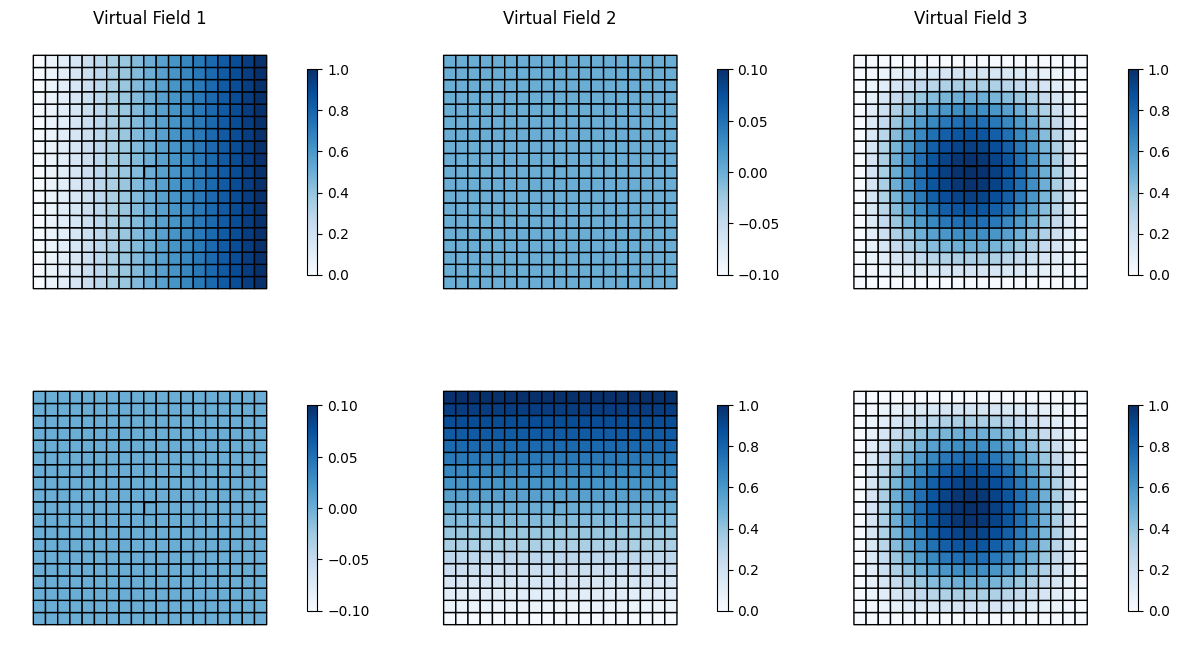

In [6]:
# Virtual fields
U1 = np.zeros([len(lmbx), 2])
U1[:,0] = element_X[:,0]
gradU1 = np.zeros([len(lmbx), 2, 2])
gradU1[:,0,0] = 1.0

U2 = np.zeros_like(U1)
U2[:,1] = element_X[:,1]
gradU2 = np.zeros([len(lmbx), 2, 2])
gradU2[:,1,1] = 1.0

U3 = np.zeros_like(U1)
U3[:,0] = np.sin(element_X[:,0]*np.pi)*np.sin(element_X[:,1]*np.pi)
U3[:,1] = np.sin(element_X[:,0]*np.pi)*np.sin(element_X[:,1]*np.pi)
gradU3 = np.zeros([len(lmbx), 2, 2])
gradU3[:,0,0] = np.cos(element_X[:,0]*np.pi)*np.sin(element_X[:,1]*np.pi)*np.pi
gradU3[:,0,1] = np.sin(element_X[:,0]*np.pi)*np.cos(element_X[:,1]*np.pi)*np.pi
gradU3[:,1,0] = np.cos(element_X[:,0]*np.pi)*np.sin(element_X[:,1]*np.pi)*np.pi
gradU3[:,1,1] = np.sin(element_X[:,0]*np.pi)*np.cos(element_X[:,1]*np.pi)*np.pi

fig, axes = plt.subplots(2,3,figsize=(15,8))

plotmesh(elements, node_x, U1[:,0], title='Virtual Field 1', ax=axes[0,0]); 
plotmesh(elements, node_x, U1[:,1], title=None, ax=axes[1,0]); 

plotmesh(elements, node_x, U2[:,0], title='Virtual Field 2', ax=axes[0,1]); 
plotmesh(elements, node_x, U2[:,1], title=None, ax=axes[1,1]); 

plotmesh(elements, node_x, U3[:,0], title='Virtual Field 3', ax=axes[0,2]); 
plotmesh(elements, node_x, U3[:,1], title=None, ax=axes[1,2]); 

U = np.stack([U1,U2,U3])
gradU = np.stack([gradU1, gradU2, gradU3])

In [7]:
W_int = []
for i in range(3):
    W_int.append(jnp.einsum('ijk,ijk', P, gradU[i]))
W_int

[Array(32.13466255, dtype=float64),
 Array(51.54538613, dtype=float64),
 Array(-1.07150635e-05, dtype=float64)]

In [8]:
Fx = 1.0
Fy = 1.2
W_ext = np.zeros(3)
W_ext[0] = Fx*len(lft_bd_elems) #Assuming every element is a unit cube, the area of each is 1 and the total area is the sum
W_ext[1] = Fy*len(top_bd_elems)
W_ext

array([19. , 22.8,  0. ])

In [10]:
params, unravel = ravel_pytree(params)
def obj_fn(params):
    loss = []
    for j in range(len(F_hist_goh)):
        lmbx = F_hist_goh[j,:,0,0]
        lmby = F_hist_goh[j,:,1,1]
        P = goh_P_vmap(lmbx, lmby, unravel(params))
        P = P[:,:2,:2]
        W_int = []
        for i in range(3):
            W_int.append(jnp.einsum('ijk,ijk', P, gradU[i]))
        W_int = jnp.array(W_int)
        loss.append(jnp.sum((W_int-W_ext)**2))
    
    return jnp.sum(jnp.array(loss))

In [11]:
sol = minimize(obj_fn, params, method="BFGS")
params = unravel(sol.x)

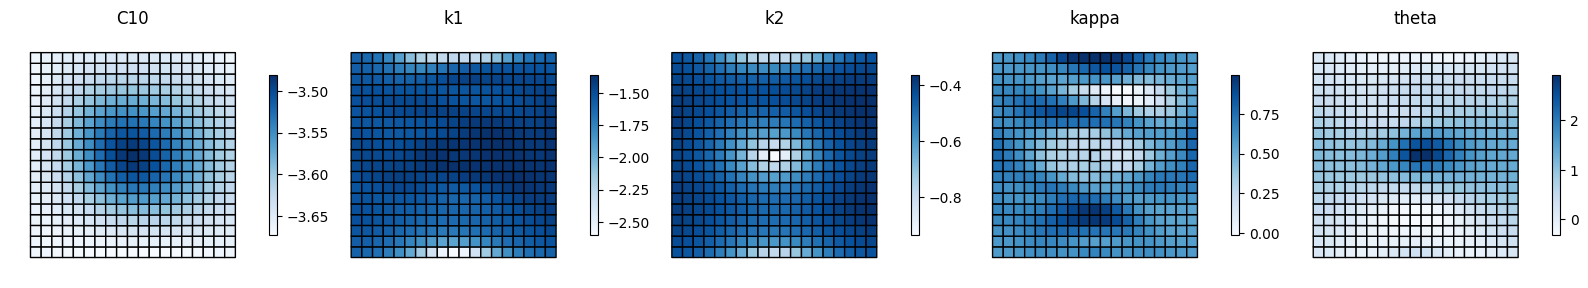

In [12]:
fig, ax = plt.subplots(1,5,figsize=(20,4))
plotmesh(elements, node_x, params[:,0], title='C10', ax=ax[0]); 
plotmesh(elements, node_x, params[:,1], title='k1', ax=ax[1]); 
plotmesh(elements, node_x, params[:,2], title='k2', ax=ax[2]); 
plotmesh(elements, node_x, params[:,3], title='kappa', ax=ax[3]); 
plotmesh(elements, node_x, params[:,4], title='theta', ax=ax[4]); 

In [13]:
np.savetxt('params/vfm_goh.npy', params)

In [14]:
pts_x = np.unique(element_x)
pts_y = np.unique(element_y)
nrow = 19
ncol = 19

class GOH_SEDF():
    def __init__(self):
        return
    
    def fiberangle(self, X):
        C10, k1, k2, kappa, theta = self.X2params(X)
        return theta
    
    def X2params(self, X):
        C10    = interp2d(X[0], X[1], pts_x, pts_y, params[:,0].reshape([nrow,ncol]))
        k1     = interp2d(X[0], X[1], pts_x, pts_y, params[:,1].reshape([nrow,ncol]))
        k2     = interp2d(X[0], X[1], pts_x, pts_y, params[:,2].reshape([nrow,ncol]))
        kappa  = interp2d(X[0], X[1], pts_x, pts_y, params[:,3].reshape([nrow,ncol]))
        theta  = interp2d(X[0], X[1], pts_x, pts_y, params[:,3].reshape([nrow,ncol]))
        return C10, k1, k2, kappa, theta

    def Psi_i(self, I1, I2, Iv, Iw, X):
        C10, k1, k2, kappa, theta = self.X2params(X)

        E = kappa*(I1-3.0) + (1-3*kappa)*(Iv-1.0)
        E = jnp.maximum(E, 0.0)

        Psi1 = C10 + k1*kappa*E*jnp.exp(k2*E**2)
        Psiv = k1*(1-3*kappa)*E*jnp.exp(k2*E**2)
        Psi2 = 0.0
        Psiw = 0.0
        return Psi1, Psi2, Psiv, Psiw

    def Psi_ii(self, I1, I2, Iv, Iw, X):
        C10, k1, k2, kappa, theta = self.X2params(X)

        E = kappa*(I1-3.0) + (1-3*kappa)*(Iv-1.0)
        E = jnp.maximum(E, 0.0)

        Psi11 =          kappa**2*k1*jnp.exp(k2*E**2)*(1+2*k2*E**2)
        Psi1v = kappa*(1-3*kappa)*k1*jnp.exp(k2*E**2)*(1+2*k2*E**2)
        Psivv =    (1-3*kappa)**2*k1*jnp.exp(k2*E**2)*(1+2*k2*E**2)

        Psi12 = Psi22 = Psi1w = Psi2v = Psi2w = Psivw = Psiww = 0.0
        return Psi11, Psi22, Psivv, Psiww, Psi12, Psi1v, Psi1w, Psi2v, Psi2w, Psivw

In [15]:
mySEDF = GOH_SEDF()
const_model = vahid_anisohyper_inv(mySEDF)
node_x_hist_goh = []
F_hist_goh = []
sigma_hist_goh = []
node_x = np.copy(node_X)
lmb_hist = [1.05, 1.10, 1.15, 1.20]
t_hist = np.arange(len(lmb_hist))
l=h=1.0
for i in range(len(lmb_hist)):
    lmb = lmb_hist[i]
    node_x, DOF_fmap = apply_bc_biax(node_x, lmx=lmb, lmy=lmb, l0=l, h0=h)
    mysolver = fe_solver_2D(node_X, node_x, elements, DOF_fmap, const_model)
    mysolver.n_print = 1
    mysolver.itermax = 20
    node_x, F, sigma = mysolver.solve()
    node_x_hist_goh.append(node_x)
    F_hist_goh.append(F)
    sigma_hist_goh.append(sigma)

    l=h=lmb
node_x_hist_goh = np.array(node_x_hist_goh)
F_hist_goh = np.array(F_hist_goh)
sigma_hist_goh = np.array(sigma_hist_goh)

Solving...
iter 1,   residual = 8.654367916384528
iter 2,   residual = 5.729148388903432
iter 3,   residual = 2.4082410509538437
iter 4,   residual = 0.7088961072117236
iter 5,   residual = 0.10981711720742328
iter 6,   residual = 0.025627903763142102
iter 7,   residual = 0.011549554144249826
iter 8,   residual = 0.005518419119222282
iter 9,   residual = 0.0026845851700444795
iter 10,   residual = 0.001314686631998147
iter 11,   residual = 0.0006456179715468827


In [ ]:
fig, axes = plt.subplots(1,4,figsize=(20,4))
strains = []
for t, node_x, F, sigma, ax in zip(t_hist, node_x_hist_goh, F_hist_goh, sigma_hist_goh, axes):
    eps_xx = F[:,0,0]-1.0
    eps_yy = F[:,1,1]-1.0

    mps = np.maximum(eps_xx, eps_yy)
    strains.append(np.array([t*np.ones_like(eps_xx), eps_xx, eps_yy]))

    plotmesh(elements, node_x, mps, title='Max. Princip. Strain [-]', ax=ax); 
strains = np.hstack(strains)